In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
sns.set(style="whitegrid")

In [3]:
data_source_dir = r"K:\Projects\sarawak_energy\data"
output_source_dir = r"K:\Projects\sarawak_energy\output"

In [4]:
def GetFile(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [5]:
xls = pd.ExcelFile(GetFile("sarawak_energy.xlsx"))

In [6]:
xls.sheet_names

['Consumption_Point_Data_Package',
 'parameters',
 'Occurrencies_Data_Package',
 'Billing_Data_Package']

In [7]:
df_dict = {}
for sheet_name in xls.sheet_names:
    df_dict[sheet_name] = xls.parse(sheet_name)

In [8]:
class LazyDict(dict):
    def keylist(self, keys, value):
        for key in keys:
            self[key] = value
    
    @staticmethod
    def add_to_dict(comps_list):
        for comps in comps_list:
            try:
                component_dict.keylist(comps[0], comps[1])
            except:
                print(comps)

In [9]:
comps_list = [
    # prioritize components
    [['illegal', 'tampering', 'teampering'], 'illegal and tampering'],
    [['inspect','insp', 'inspection','inpection','check', 'checking', 'checked'], 'inspection'],
    [['disconnect','disconnected', 'disconnection'], 'disconnect'], 
    [['read', 'reading'], 'reading'],
    [['arrears'], 'arrears'],
    [['displ', 'display'], 'no display'],
    [['change', 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'changing'],
    [['faulty'], 'faulty'],
    [['install', 'installation','new move in'], 'installing'],
    [['jammed'], 'jamming'],
    [['operation', 'opps', 'ops'], 'operating'],
    [[ 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'replacing'],
    [['reconnect', 'reconnection'], 'reconnecting'],
    [[ 'retest', 'retesting', 'test', 'testing'], 'testing'],
    [['upgrade', 'upgrading'], 'upgrading'],
    [['missing'], 'missing']
    
]

In [10]:
component_dict = LazyDict()
component_dict.add_to_dict(comps_list)

In [11]:
def add_component(description, component_dict):
    for comp in component_dict:
        if comp in description:
            return component_dict[comp]

    return "other"

In [12]:
def cleanse_df_cp(df_cp):
    
    non_null_cols = df_cp.isna().all()[df_cp.isna().all()==False].index.tolist()
    df_cp = df_cp[non_null_cols]
    df_cp.drop(["MoveIn", "MoveOut", "billing_factor"], inplace=True, axis = 1)
    
    df_cp["was_fraud"] = df_cp["was_fraud"].replace("S", 1)
    df_cp["was_fraud"] = df_cp["was_fraud"].replace(np.nan, 0)
    df_cp["was_fraud"] = df_cp["was_fraud"].astype(int)
    
    df_cp.rename(columns={'id':'id_uc'}, inplace=True)
    
    return df_cp

In [13]:
def spell_correct(description):
    
    description = description.lower()
    
    # remove numbers and special characters
    description = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', description)
    #description = TextBlob(description)
    #description = str(description.correct())
    
    return description

In [14]:
def cleanse_df_op(df_op):
    
    non_null_cols = df_op.isna().all()[df_op.isna().all()==False].index.tolist()

    df_op = df_op[non_null_cols]
    
    df_op["Desc"] = df_op["Desc"].apply(spell_correct)
    
    df_op["activity"] = df_op["Desc"].apply(add_component, component_dict=component_dict)
    
    return df_op

In [15]:
def cleanse_df_bp(df_bp):
    
    non_null_cols = df_bp.isna().all()[df_bp.isna().all()==False].index.tolist()

    df_bp = df_bp[non_null_cols]
    
    # replacing the nans with zeros
    df_bp.replace(np.nan, 0.0, inplace=True)
    
    return df_bp

In [16]:
def cleanse_df(df_dict):
    
    df_cp = cleanse_df_cp(df_dict['Consumption_Point_Data_Package'])
    
    df_op = cleanse_df_op(df_dict['Occurrencies_Data_Package'])
    
    df_bp = cleanse_df_bp(df_dict['Billing_Data_Package'])
    
    return df_cp, df_op, df_bp

In [17]:
df_cp, df_op, df_bp = cleanse_df(df_dict)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
k:\anaconda3\lib\site-packages\ipykernel_

# Feature Engineering

## Pilot

* column for negative values
* remove negative values
* data normalization using min max scaler per customer
* Remove rows with less than 6 months data
* Dump it onto tsfresh first

## Features

### Paper 1
* Average consumption of last x months
* Maximum consumption of last x months
* Stdev consumption of last x months
* Number of inspection remarks last x months or suspect tampering
* Average consumption of residential area

### Paper 2
* Abrupt decrease in consumption
* Long period of low consumption compared to average
* Consumption discrepancy
* Consumption peak - Consumption in a month x% times higher/lower than
the previous and the following month.
* Billing/consumption similarity - (only in gas)
* Unknown consumption - Number of consecutive estimated readings, consecutive 0 or NULL consumption (in the present and historically)
* Negative Consumption - Whether the customer has a negative consumption (e.g. count was reset at the installation of a new meter)
* Reading correction, reset, or suspected tampering

# Further filtering

Filter out the following:

## Customers with less than 6 points of data
* 5% of customers removed
* 2 fraud customers were removed, remaining is 48
* 16 non-fraud customers were removed, 285 remaining

# Feasibility test

## Further issues with time series
* Discontinuous time series (not continuous)
* NULL values
* Multiple readings in a month
* Negative meter reading - meter reset
* Zero value - estimated reading
* How to compare with average ? - local ? set fixed time points ?
* Missing months in between

## ToDo

* Solve time series problems of discontinuity 
* Groupby resample mean
* Compute new set of features 
* Remember to compute using **% percentage drop** as need to normalize
* Consider normalizing data (global or local)

* Compute long time series from average
* Think of ways to capture the drops 

In [18]:
def filtering(df_cp, df_op, df_bp):
    
    months_count =df_bp.groupby(['id_uc']).count()['date_reference'].reset_index()
    customers_filtered = list(months_count.query('date_reference >= 6')['id_uc'].unique())
    df_cp_filtered = df_cp[df_cp["id_uc"].isin(customers_filtered)]
    df_op_filtered = df_op[df_op["id_uc"].isin(customers_filtered)]
    df_bp_filtered = df_bp[df_bp["id_uc"].isin(customers_filtered)]
    
    return df_cp_filtered, df_op_filtered, df_bp_filtered

In [19]:
df_cp_filtered, df_op_filtered, df_bp_filtered = filtering(df_cp, df_op, df_bp)

# Pilot with tsfresh for df_bp

* Quick way to see if any good features can be computed with tsfresh

In [23]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_fscore_support

In [24]:
y = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

df_bp_ts = df_bp_filtered.sort_values(['id_uc', 'date_reference']).drop(['date_measured', 'ReadType'], axis=1)

assert (len(y) == len(df_bp_ts['id_uc'].unique())), print("unique elements do not match")

In [25]:
fraudsters = list(df_cp[df_cp['was_fraud'] == 1]['id_uc'])

In [39]:
df_bp_filtered[df_bp_filtered['consumption_invoiced'] != df_bp_filtered['consumption_measured']]

id_uc date_reference    Read  Billed  consumption_invoiced  \
8      301045595109     2011-11-28   48322   48322               99522.0   
10     301045595109     2008-05-22   28855   28855               99702.0   
416    201166979103     2002-11-21       5     143                   0.0   
467    201166979103     2002-09-20       5     143                   0.0   
483    201166979103     2002-07-19       5       6                   0.0   
493    201107015108     2016-12-09   39698   39698             9999250.0   
510    201107015108     2017-06-09   39809   39809             9997661.0   
530    201107015108     2018-06-08   59978   59978             9981844.0   
579    201088668102     2015-02-17   16354   16354             9994747.0   
674    201088662100     2002-12-20   13946   13946               25742.0   
675    201088662100     2002-12-20   13946   13946               25742.0   
1182   201088662100     2012-01-18  244484  244484              251660.0   
1183   201088662100     2012-01-18  244484  244484              251660.0   
1314   201088662100     2011-01-17    9756    9756               24645.0   
1315   201088662100     2011-01-17    9756    9756               24645.0   
1326   201088662100     2007-02-16   10993   10993               16598.0   
1327   201088662100     2007-02-16   10993   10993               16598.0   
1391   100006061947     2018-07-25    1263    1263             9999970.0   
1514   100005958216     2018-07-06    5941    5941             9999857.0   
1536   100005946135     2018-04-09       0       0               80012.0   
1550   100005946123     2018-04-09       2       2               99786.0   
1552   100005946123     2018-02-09       2       2               98947.0   
2026   100005535810     2016-11-07      36      36               99945.0   
2279   100005301069     2016-04-22       8       8             9998599.0   
2904   100005291817     2016-04-22      10      10               99986.0   
3092   100005204027     2015-12-09      36      36               99967.0   
3376   100005126107     2017-06-23    3554    3554               99775.0   
3657   100004928897     2015-11-19    3294    3294               99721.0   
3705   100004903803     2015-07-22     690     690             9996890.0   
3732   100004878080     2015-11-12     734     734             9999915.0   
...             ...            ...     ...     ...                   ...   
17833  100004371246     2014-11-18   58841   58841             9999939.0   
17878  100004621524     2016-04-14   23238   23238               99571.0   
17882  100004621524     2015-12-14   21960   21960               99970.0   
17921  100004768572     2015-09-23   13203   13203             9998767.0   
17923  100004768572     2015-07-24   13047   13047             9999210.0   
17950  100004840386     2015-09-22     925     925               99855.0   
17973  100005222807     2016-09-23   12776   12776             9999627.0   
18041  201048053100     2016-08-18   46135   46135               99775.0   
18055  201048053100     2015-06-18   42693   42693               99337.0   
18089  201048053100     2012-08-17   35697   35697               99848.0   
18143  201048053100     2008-02-18   25401   25401               99970.0   
18234  201059464108     2015-05-19   99174   99174              998104.0   
18399  301021694101     2012-02-10   27867   27867               99944.0   
18462  301021694101     2006-11-10    8944    8944               99435.0   
18489  301021694101     2004-08-12      15      15                 360.0   
18552  301024116104     2014-06-12     556     556                 627.0   
18587  301024116104     2011-07-12   82100   82100               99977.0   
18791  301024145104     2009-08-12   25201   25201               99931.0   
19001  301026332102     2008-03-10   44867   44867               99975.0   
19107  301049087100     2016-06-03    7436    7436             9998889.0   
19412  401016009113     2015-05-06   36385   36385            

In [32]:
df_bp_ts[df_bp_ts['id_uc']==100002962051]

id_uc date_reference  Read  Billed  consumption_invoiced  \
9471   100002962051     2015-04-09     0       0                   0.0   
9472   100002962051     2015-05-04   839     839                 839.0   
9470   100002962051     2015-05-12   839     839                   0.0   
17237  100002962051     2017-02-07     0       0                   0.0   
17236  100002962051     2017-03-03   152     152                 152.0   
17235  100002962051     2017-03-06  4000    4000                3848.0   

       consumption_measured  value_measured  
9471                    0.0               0  
9472                  839.0             839  
9470                    0.0             839  
17237                   0.0               0  
17236                 152.0             152  
17235                3848.0            4000

In [29]:
df_bp[df_bp['id_uc'].isin(fraudsters)].groupby('id_uc').size().sort_values()

id_uc
100005692800      4
301075238101      6
100002962051      6
301056181106     11
301072343104     11
100004363638     11
100005582680     14
100004161914     14
301049087100     17
100005143774     20
100004532229     20
301035812106     26
100005222807     28
100005450014     34
100004621524     37
100004173436     39
100004286450     40
301009148103     43
100003988011     45
100004220591     46
401005754120     49
100005541263     50
100004768572     50
100004840386     52
100003721183     62
100004286462     65
100004278490     66
100003421680     72
100004371246     80
100003477960     90
100002902443     91
201059464108     99
100004210433    100
100004134340    102
100002248070    110
100001786617    112
100002189313    154
100003441514    162
100000653580    163
201048053100    179
401017049106    180
301024145104    181
301024116104    181
301021694101    185
401016009113    189
401003209101    191
401021326106    191
301026332102    193
401048279102    194
dtype: int64

In [24]:
extraction_settings = ComprehensiveFCParameters()
df_bp_X = extract_relevant_features(df_bp_ts, y.set_index('id_uc')['was_fraud'], column_id='id_uc', column_sort='date_reference', default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  3.49s/it]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_bp_X, y['was_fraud'], test_size=0.2, shuffle=True, stratify=y['was_fraud'])

# Try XGBOOST Here

In [59]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        57
           1       0.56      0.50      0.53        10

   micro avg       0.87      0.87      0.87        67
   macro avg       0.73      0.71      0.72        67
weighted avg       0.86      0.87      0.86        67



In [60]:

print(f"Precision is {precision_score(y_test, cl.predict(X_test))}")
print(f"Recall is {recall_score(y_test, cl.predict(X_test))}")
print(f"F1 Score is : {f1_score(y_test, cl.predict(X_test))}")

Precision is 0.5555555555555556
Recall is 0.5
F1 Score is : 0.5263157894736842


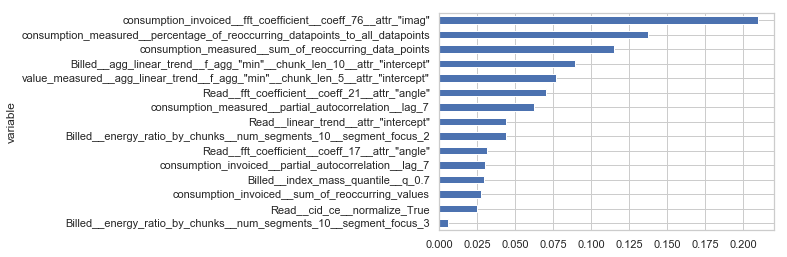

In [61]:
pd.Series(cl.feature_importances_, index=X_train.columns).sort_values(ascending=True)[-15:].plot(kind='barh', color='b')

## Cross Validation

In [223]:
f1_scores = cross_val_score(cl, df_bp_X, y['was_fraud'], cv = StratifiedKFold(shuffle=True, random_state=23333, n_splits=5), scoring='f1',n_jobs=-1, verbose=0)


In [224]:
f1_scores

array([0.36363636, 0.52631579, 0.4137931 , 0.73684211, 0.31578947])

# Data that could help improve the model

* Date of the fraud - (dataset of frauds and others in the last 6 months)
    * Then we can have a fix lookback time
* Credit worthiness ranking of customer - did they pay in time or not
* Smart meter load profile of customer
* More fraud data
* Past fraud data